In [1]:
import pandas as pd
import sklearn
import numpy as np

In [2]:
df = pd.read_csv("../Binance/btcusdt.csv")
df

,Unnamed: 0,Open,Close,High,Low
0,0,20762.000000,20763.544871,20763.544871,20762.000000
1,1,20763.544871,20765.089742,20765.089742,20763.544871
2,2,20765.089742,20766.634613,20766.634613,20765.089742
3,3,20766.634613,20768.179484,20768.179484,20766.634613
4,4,20768.179484,20769.724356,20769.724356,20768.179484
...,...,...,...,...,...
17909,17909,21057.070381,21058.615252,21058.615252,21057.070381
17910,17910,21058.615252,21055.525510,21058.615252,21055.525510
17911,17911,21055.525510,21053.980639,21055.525510,21053.980639
17912,17912,21053.980639,21052.435768,21053.980639,21052.435768


In [3]:
# #Check if any zero volumes are available
# indexZeros = df[ df['Volume'] == 0 ].index

# df.drop(indexZeros , inplace=True)
# df.loc[(df["Volume"] == 0 )]
# df.isna().sum()

In [4]:
df.head()

,Unnamed: 0,Open,Close,High,Low
0,0,20762.000000,20763.544871,20763.544871,20762.000000
1,1,20763.544871,20765.089742,20765.089742,20763.544871
2,2,20765.089742,20766.634613,20766.634613,20765.089742
3,3,20766.634613,20768.179484,20768.179484,20766.634613
4,4,20768.179484,20769.724356,20769.724356,20768.179484


In [5]:
import pandas_ta as ta

In [6]:
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['EMA55'] = df.ta.ema(length=55)
df['EMA21'] = df.ta.ema(length=21)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

In [7]:
backrollingN = 6

In [8]:
df['slopeRSI'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeEMA55'] = df['EMA55'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeEMA21'] = df['EMA21'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [9]:
df = df.dropna()

In [10]:
df

,Unnamed: 0,Open,Close,High,Low,ATR,RSI,EMA55,EMA21,slopeRSI,slopeEMA55,slopeEMA21
59,59,20754.275644,20755.820516,20755.820516,20754.275644,1.580311,82.860037,20744.084617,20743.623024,1.500095,0.349639,1.148608
60,60,20755.820516,20757.365387,20757.365387,20755.820516,1.578539,84.065808,20744.558930,20744.872330,1.396887,0.392325,1.184632
61,61,20757.365387,20758.910258,20758.910258,20757.365387,1.576856,85.187967,20745.071478,20746.148505,1.300522,0.433488,1.217381
62,62,20758.910258,20760.455129,20760.455129,20758.910258,1.575257,86.232146,20745.620894,20747.449107,1.210582,0.473180,1.247153
63,63,20760.455129,20762.000000,20762.000000,20760.455129,1.573737,87.203622,20746.205862,20748.771916,1.126668,0.511455,1.274218
...,...,...,...,...,...,...,...,...,...,...,...,...
17909,17909,21057.070381,21058.615252,21058.615252,21057.070381,1.824568,71.233973,21045.725304,21049.672439,2.097566,0.395655,0.751923
17910,17910,21058.615252,21055.525510,21058.615252,21055.525510,1.887827,62.884738,21046.075311,21050.204536,0.544951,0.413052,0.763819
17911,17911,21055.525510,21053.980639,21055.525510,21053.980639,1.870679,59.151546,21046.357645,21050.547818,-1.201178,0.399877,0.698394
17912,17912,21053.980639,21052.435768,21053.980639,21052.435768,1.854388,55.597100,21046.574720,21050.719450,-2.791588,0.357220,0.562676


In [11]:
#Target flexible way
pipdiff = 500*1e-5 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [12]:
# mytarget(barsfront to take into account, dataframe)
df['mytarget'] = mytarget(16, df)
df.tail()

C:\Users\hites\AppData\Local\Temp/ipykernel_34772/2438764458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mytarget'] = mytarget(16, df)


,Unnamed: 0,Open,Close,High,Low,ATR,RSI,EMA55,EMA21,slopeRSI,slopeEMA55,slopeEMA21,mytarget
17909,17909,21057.070381,21058.615252,21058.615252,21057.070381,1.824568,71.233973,21045.725304,21049.672439,2.097566,0.395655,0.751923,NaN
17910,17910,21058.615252,21055.525510,21058.615252,21055.525510,1.887827,62.884738,21046.075311,21050.204536,0.544951,0.413052,0.763819,NaN
17911,17911,21055.525510,21053.980639,21055.525510,21053.980639,1.870679,59.151546,21046.357645,21050.547818,-1.201178,0.399877,0.698394,NaN
17912,17912,21053.980639,21052.435768,21053.980639,21052.435768,1.854388,55.597100,21046.574720,21050.719450,-2.791588,0.357220,0.562676,NaN
17913,17913,21052.435768,21050.890897,21052.435768,21050.890897,1.838913,52.217930,21046.728870,21050.735036,-3.893583,0.292441,0.379106,NaN


In [13]:
df = df.dropna()
attributes = ['ATR', 'RSI', 'EMA55', 'EMA21', 'slopeRSI', 'slopeEMA55', 'slopeEMA21']
x = df[attributes]
y = df['mytarget']
print(x)

            ATR        RSI         EMA55         EMA21  slopeRSI  slopeEMA55  \
59     1.580311  82.860037  20744.084617  20743.623024  1.500095    0.349639   
60     1.578539  84.065808  20744.558930  20744.872330  1.396887    0.392325   
61     1.576856  85.187967  20745.071478  20746.148505  1.300522    0.433488   
62     1.575257  86.232146  20745.620894  20747.449107  1.210582    0.473180   
63     1.573737  87.203622  20746.205862  20748.771916  1.126668    0.511455   
...         ...        ...           ...           ...       ...         ...   
17891  1.932670  46.796798  21043.161245  21047.336891 -3.551510    0.180123   
17892  1.913280  44.115944  21043.161434  21046.957768 -2.915216    0.118516   
17893  1.894859  41.552417  21043.106443  21046.472668 -2.798334    0.059110   
17894  1.877360  39.105259  21042.998241  21045.891225 -2.681145    0.001825   
17895  1.937979  45.960067  21043.004252  21045.643527 -1.251845   -0.029769   

       slopeEMA21  
59       1.148608  

In [14]:
df.isna().sum()

Unnamed: 0    0
Open          0
Close         0
High          0
Low           0
ATR           0
RSI           0
EMA55         0
EMA21         0
slopeRSI      0
slopeEMA55    0
slopeEMA21    0
mytarget      0
dtype: int64

In [22]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=2)

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [24]:
model = DecisionTreeRegressor(criterion='mae', splitter='random')

In [25]:
model.fit(xtrain, ytrain)

y_pred_train = model.predict(xtrain)
y_pred_test = model.predict(xtest)

In [26]:
from sklearn.metrics import accuracy_score
accurancy_train = accuracy_score(ytrain, y_pred_train)
accuracy_tesst = accuracy_score(ytest, y_pred_test)

print("accuracy train %.f%% "% (accurancy_train*100))
print("accuracy test %.f%% "% (accuracy_tesst*100))

accuracy train 100% 
accuracy test 70% 


In [27]:
print(df['mytarget'].value_counts()*100/df['mytarget'].count())


pred_test = np.random.choice([0,1,2], len(y_pred_test))
accuracy_tesst = accuracy_score(ytest, pred_test)
print("accuracy gambler %.2f%%" %(accuracy_tesst*100))

2.0    50.524191
1.0    49.475809
Name: mytarget, dtype: float64
accuracy gambler 32.79%


In [28]:
train_index = int(0.8 * len(x))
xtrain, xtest = x[:train_index], x[train_index:]
ytrain, ytest = y[:train_index], y[train_index:]

In [29]:
model2 = DecisionTreeRegressor(criterion='mae', splitter='random')
# model2 = DecisionTreeRegressor(criterion='mae')
# model2 = DecisionTreeRegressor()
model2.fit(xtrain, ytrain)

y_pred_train = model.predict(xtrain)
y_pred_test = model.predict(xtest)

In [30]:
from sklearn.metrics import accuracy_score
accurancy_train = accuracy_score(ytrain, y_pred_train)
accuracy_tesst = accuracy_score(ytest, y_pred_test)

print("accuracy train %.f%% "% (accurancy_train*100))
print("accuracy test %.f%% "% (accuracy_tesst*100))

accuracy train 94% 
accuracy test 93% 


In [31]:
xpred = model.predict(xtest)
r2_score(ytest, xpred)

0.7391706849347011

In [32]:
print(df['mytarget'].value_counts()*100/df['mytarget'].count())


pred_test = np.random.choice([0,1,2], len(y_pred_test))
accuracy_tesst = accuracy_score(ytest, pred_test)
print("accuracy gambler %.2f%%" %(accuracy_tesst*100))

2.0    50.524191
1.0    49.475809
Name: mytarget, dtype: float64
accuracy gambler 32.96%


In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd



# Create the contingency mat
matrix_test = confusion_matrix(ytest, y_pred_test)
matrix_train = confusion_matrix(ytrain, y_pred_train)
classification_report_pred = classification_report(ytest, y_pred_test)

# Convert the matrix to a DataFrame for easy display
matrix_df_test = pd.DataFrame(matrix_test)#, columns=['pred_Sideways_trend', 'pred_Downtrend','pred_Uptrend'], index=['Sideways_trend', 'Downtrend','Uptrend'])

matrix_df_train = pd.DataFrame(matrix_train)#, columns=['pred_Sideways_trend', 'pred_Downtrend','pred_Uptrend'], index=['Sideways_trend', 'Downtrend','Uptrend'])

print(matrix_df_test)
print("=============================================================================")
print(matrix_df_train)
print("=============================================================================")
print(classification_report_pred)

      0     1
0  1558   131
1   101  1778
      0     1
0  6743   393
1   437  6696
              precision    recall  f1-score   support

         1.0       0.94      0.92      0.93      1689
         2.0       0.93      0.95      0.94      1879

    accuracy                           0.93      3568
   macro avg       0.94      0.93      0.93      3568
weighted avg       0.94      0.93      0.93      3568



In [36]:
from matplotlib import pyplot as plt

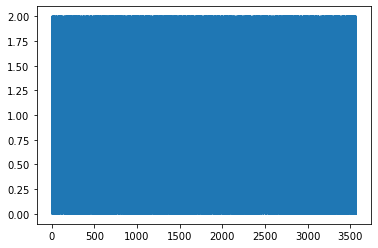

In [37]:
plt.plot(pred_test)